In [1]:
"""
Script: System Kinematics: Analysis of the Ankle joint
Group Members: Shih-Heng Chen, Kevin Abishek, Mohammad Zaki Patel, Aakash Varma
"""
! pip install pynamics

%matplotlib inline

     |████████████████████████████████| 87 kB 1.8 MB/s 


In [2]:
"""
Importing libraries
"""

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.output import Output,PointsOutput
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
import scipy.optimize

In [3]:
system = System()
pynamics.set_system(__name__,system)

In [4]:
"""
Defining Link lengths:

All lengths are in meters (m)
"""

lFoot = Constant(0.2,'lFoot',system)
hAnk = Constant(0.051,'hAnk',system)
lCalc = Constant(0.053,'lCalc',system)
lShank = Constant(0.385,'lShank',system)

print(system.constant_values)

{lFoot: 0.2, hAnk: 0.051, lCalc: 0.053, lShank: 0.385}


In [5]:
"""
Defining differentiable variables:
qA -> foot-ground angle
qB -> foot-shank angle
"""

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)

In [6]:
"""
Defining initial conditions that represent toe-off during bipedal running:
"""

InitialAnkAngle = -25*pi/180
center_qB_angle = 90*pi/180

initialvalues = {}
initialvalues[qA]= 20*pi/180
initialvalues[qB]= InitialAnkAngle + center_qB_angle

"""
Processvalues represent system states through which kinematics data will be iteratively calculated
"""

processvalues = {}
processvalues[qA]= 20*pi/180
processvalues[qB]= InitialAnkAngle + center_qB_angle

print(initialvalues)

{qA: 0.3490658503988659, qB: 1.1344640137963142}


In [7]:
"""
Creating Frames to be used in the system:
N -> fixed frame
Fank -> Frame of the ankle
Fknee -> Frame of the knee
"""

N = Frame('N',system)
Fank = Frame('Fank',system)
Fknee = Frame('Fknee',system)

In [8]:
system.set_newtonian(N)

In [9]:
"""
Defining frame orientations w.r.t. each other:
"""

Fank.rotate_fixed_axis(N,[0,0,1],qA,system)
Fknee.rotate_fixed_axis(Fank,[0,0,1],qB,system)

In [10]:
"""
Defining lower limb landmark points:
Ptoe -> Point of contact between foot and ground
Pcalc -> Position of calcaneus bone
Pank -> Position of ankle joint
Pknee -> Position of knee joint
"""

Ptoe = 0*N.x + 0*N.y + 0*N.z
Pcalc = Ptoe + lFoot*Fank.x
Pank = Ptoe + ((lFoot - lCalc)*Fank.x) + hAnk*Fank.y
Pknee = Pank + lShank*Fknee.x
print(Pcalc)

lFoot*Fank.x


In [11]:
#Creating the list of points:

points = list([Ptoe, Pcalc, Pank, Pknee])

points

[0,
 lFoot*Fank.x,
 hAnk*Fank.y + Fank.x*(-lCalc + lFoot),
 hAnk*Fank.y + lShank*Fknee.x + Fank.x*(-lCalc + lFoot)]

In [12]:
"""
Extracting x and y coordinates of the points. Will be used to plot a toe-off pose of the system:
"""

px = [pt.dot(N.x).subs(system.constant_values).subs(initialvalues) for pt in points]
py = [pt.dot(N.y).subs(system.constant_values).subs(initialvalues) for pt in points]
pxmuscle = [px[1], px[3]]
pymuscle = [py[1], py[3]]

print(px)
print(py)

[0, 0.187938524157182, 0.120691787945919, 0.154246748903768]
[0, 0.0684040286651337, 0.0982012847289546, 0.481736243494277]


In [13]:
"""
Extracting plot parameters to set limits of axes:
"""

xlim = max(px)
ylim = max(py)
ulim = max([xlim, ylim])

xlim = min(px)
ylim = min(py)
llim = min([xlim, ylim])

print(ulim)
print(llim)

0.481736243494277
0


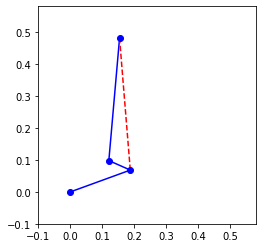

In [14]:
"""
Plotting toe-off pose of the ankle during bipedal running:
"""

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(px,py,'b')
plt.plot(pxmuscle,pymuscle,'r--')
for ptx, pty in zip(px, py):
    plt.plot(ptx,pty,'bo')
plt.xlim(float(llim)-0.1,float(ulim)+0.1)
plt.ylim(float(llim)-0.1,float(ulim)+0.1)
ax.set_aspect('equal', adjustable='box')

In [15]:
"""
Defining joint velocities:

units in deg/s
"""

processvalues[qA_d] = 0
processvalues[qB_d] = 1200*pi/180

In [16]:
"""
Defining limits of the ankle joint

units in deg
"""

AnkAngle_llim = -15
AnkAngle_ulim = 30

In [17]:
"""
Ankle_vals holds an array of ankle positions through which kinematics is to be analysed:
"""

Ankle_vals = numpy.arange(AnkAngle_llim, AnkAngle_ulim)

Ankle_vals

array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29])

In [18]:
"""
Muscle length and velocity vectorization:

An ideal dorsiflexor muscle is considered to be connecting the knee to the calcaneus bone. The ankle frame of reference is used.
"""

Vmuscle_cont = (Pcalc.express(Fank) - Pknee.express(Fank)).time_derivative(N, system)

Vmuscle_cont

Fank.x*(lShank*qB_d*sin(qB) - qA_d*(-hAnk - lShank*sin(qB))) + Fank.y*(-lShank*qB_d*cos(qB) + qA_d*(lCalc - lShank*cos(qB)))

In [19]:
"""
Extracting muscle contraction velocities in the x,y and net directions:
"""

V_fiber_contractionX = []
V_fiber_contractionY = []
V_fiber_contractionNet = []

for ang in Ankle_vals:
    processvalues[qB]= (ang*pi/180) + center_qB_angle
    vx = ((Vmuscle_cont.dot(Fank.x)).subs(system.constant_values).subs(processvalues)).evalf()
    vy = ((Vmuscle_cont.dot(Fank.y)).subs(system.constant_values).subs(processvalues)).evalf()
    V_fiber_contractionX.append(vx)
    V_fiber_contractionY.append(vy)
    V_fiber_contractionNet.append(((vx**2)+(vx**2))**0.5)

Text(0, 0.5, 'm/s')

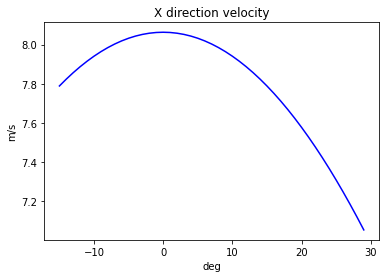

In [20]:
# Plotting x direction contraction velocity
plt.plot(Ankle_vals,V_fiber_contractionX,'b')
plt.title("X direction velocity")
plt.xlabel("deg")
plt.ylabel("m/s")

Text(0, 0.5, 'm/s')

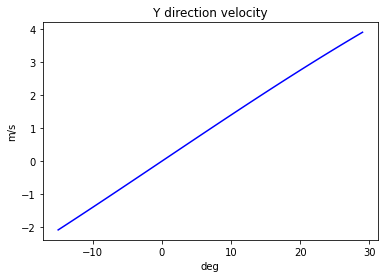

In [21]:
# Plotting y direction contraction velocity
plt.plot(Ankle_vals,V_fiber_contractionY,'b')
plt.title("Y direction velocity")
plt.xlabel("deg")
plt.ylabel("m/s")

Text(0, 0.5, 'm/s')

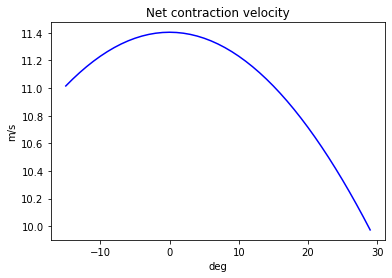

In [22]:
# Plotting net contraction velocity
plt.plot(Ankle_vals,V_fiber_contractionNet,'b')
plt.title("Net contraction velocity")
plt.xlabel("deg")
plt.ylabel("m/s")

In [23]:
"""
Considering Knee as the end effector and the toe as fixed to the ground, the velocities of the knee as calculated using Jacobian
Jk as follows:
"""

Vknee = Pknee.time_derivative(N, system)

Vkx = Vknee.dot(N.x)
Vky = Vknee.dot(N.y)

print(Vkx)
print(Vky)

vk = sympy.Matrix((Vkx, Vky))
qd = sympy.Matrix((qA_d, qB_d))

Jk = vk.jacobian(qd)

print(Jk)

-hAnk*qA_d*cos(qA) - lShank*(qA_d + qB_d)*sin(qA)*cos(qB) - lShank*(qA_d + qB_d)*sin(qB)*cos(qA) - qA_d*(-lCalc + lFoot)*sin(qA)
-hAnk*qA_d*sin(qA) - lShank*(qA_d + qB_d)*sin(qA)*sin(qB) + lShank*(qA_d + qB_d)*cos(qA)*cos(qB) + qA_d*(-lCalc + lFoot)*cos(qA)
Matrix([[-hAnk*cos(qA) - lShank*sin(qA)*cos(qB) - lShank*sin(qB)*cos(qA) + (lCalc - lFoot)*sin(qA), -lShank*sin(qA)*cos(qB) - lShank*sin(qB)*cos(qA)], [-hAnk*sin(qA) - lShank*sin(qA)*sin(qB) + lShank*cos(qA)*cos(qB) + (-lCalc + lFoot)*cos(qA), -lShank*sin(qA)*sin(qB) + lShank*cos(qA)*cos(qB)]])


In [24]:
"""
Subject weight, and accelerations of the knee are defined here. These are the loads acting on the knee (end effector):

Units are:
wt: Kg
accel_x: m/(s^2)
accel_y: m/(s^2)

Ank_torque: Nm
"""

wt = 1
accel_x = 0
accel_y = -9.8

Fnet = sympy.Matrix([[wt*accel_x], [wt*accel_y]])

# Calculating Ankle torque:
Ank_torque = ((Jk.T).subs(system.constant_values).subs(initialvalues))*Fnet

print(Ank_torque)

Matrix([[-1.51161813925693], [-0.328838617386915]])


In [25]:
"""
Using Vector opoerations, the torques (obtained from the previous step) are translated to muscle force data:
Fmusclefiber is the tension force that actuates the ankle joint during toe-off.
Units are [N/kg (if wt is 1kg), N (if otherwise)]
"""

P = Pank.express(Fank)
A1 = Pcalc.express(Fank)
A2 = Pknee.express(Fank)
D = A1-A2

# Calculating perpendicular distance from Ankle to muscle fiber
d = (((A1-P).cross(D)).length().subs(system.constant_values).subs(initialvalues))/(D.length().subs(system.constant_values).subs(initialvalues))

Fmusclefiber = Ank_torque[1]/d

print(Fmusclefiber)

-5.09009604560691
